In [5]:

###   1. 로지스틱 회귀 이해하기 
# 선형 회귀와 달리 로지스틱 회귀는 같은 확률로 (0,1) 간격으로 제한되어 값을 예측할 수 있다. 로지스틱 회귀는 확률 또는 비율을 예측하기 위한 이동 방법으로, 선형 회귀와 마찬가지로 로지스틱 회귀 모델의 계수는 조언으로 취급될 수 있다. 또한 이진 분류 문제에 대해 효과적인 최우선 방법이다.

##  1.1 데이터 불러오기 
getwd()
dir()
load("NatalRiskData.rData")

train <- sdata[sdata$ORIGRANDGROUP<=5,]
test <- sdata[sdata$ORIGRANDGROUP>5,]

colnames(sdata)
table(sdata$atRisk)
table(sdata$DPLURAL)

[1] "C:/Users/seung/OneDrive/R/Rstudy_Dangsan/linear_regression"

[1] "chapter7.2"              "chapter7.2.R"           
[3] "chapter7.R"              "linear_regression.Rproj"
[5] "NatalRiskData.rData"     "psub.RData"             
[7] "Untitled.ipynb"          "Untitled1.ipynb"

[1] "PWGT"          "UPREVIS"       "CIG_REC"       "GESTREC3"     
 [5] "DPLURAL"       "ULD_MECO"      "ULD_PRECIP"    "ULD_BREECH"   
 [9] "URF_DIAB"      "URF_CHYPER"    "URF_PHYPER"    "URF_ECLAM"    
[13] "atRisk"        "DBWT"          "ORIGRANDGROUP"


FALSE  TRUE 
25831   482 


           single triplet or higher              twin 
            25440                44               829 

In [6]:

## 2. 로지스틱 회귀 모델 만들기

complications <- c("ULD_MECO", "ULD_PRECIP", "ULD_BREECH")

riskfactors <- c("URF_DIAB", "URF_CHYPER", "URF_PHYPER","URF_ECLAM") # 좌부터 당뇨 / 고혈압 / 임신고혈압 / 임신중독증 여부  TRUE | FALSE

y <- "atRisk"
x <- c("PWGT", "UPREVIS", "CIG_REC", "GESTREC3", "DPLURAL", complications, riskfactors)
x
fmla <- paste(y, paste(x, collapse = "+"), sep = "~")

model <- glm(fmla, data = train, family=binomial(link="logit"))
summary(model)

[1] "PWGT"       "UPREVIS"    "CIG_REC"    "GESTREC3"   "DPLURAL"   
 [6] "ULD_MECO"   "ULD_PRECIP" "ULD_BREECH" "URF_DIAB"   "URF_CHYPER"
[11] "URF_PHYPER" "URF_ECLAM"


Call:
glm(formula = fmla, family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9732  -0.1818  -0.1511  -0.1358   3.2641  

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -4.412189   0.289352 -15.249  < 2e-16 ***
PWGT                      0.003762   0.001487   2.530 0.011417 *  
UPREVIS                  -0.063289   0.015252  -4.150 3.33e-05 ***
CIG_RECTRUE               0.313169   0.187230   1.673 0.094398 .  
GESTREC3< 37 weeks        1.545183   0.140795  10.975  < 2e-16 ***
DPLURALtriplet or higher  1.394193   0.498866   2.795 0.005194 ** 
DPLURALtwin               0.312319   0.241088   1.295 0.195163    
ULD_MECOTRUE              0.818426   0.235798   3.471 0.000519 ***
ULD_PRECIPTRUE            0.191720   0.357680   0.536 0.591951    
ULD_BREECHTRUE            0.749237   0.178129   4.206 2.60e-05 ***
URF_DIABTRUE             -0.346467   0.287514  -1.205 0.22

In [8]:

train$pred <- predict(model, newdata= train, type="response")
test$pred <- predict(model, newdata = test, type="response")
# type = "response" = 예측된 확률값 y를 반환하도록 한다. 만일 없다면, 기본적으로 predict() 함수는 link 함수인 logit(y)를 결괏값으로 줄 것 이다.


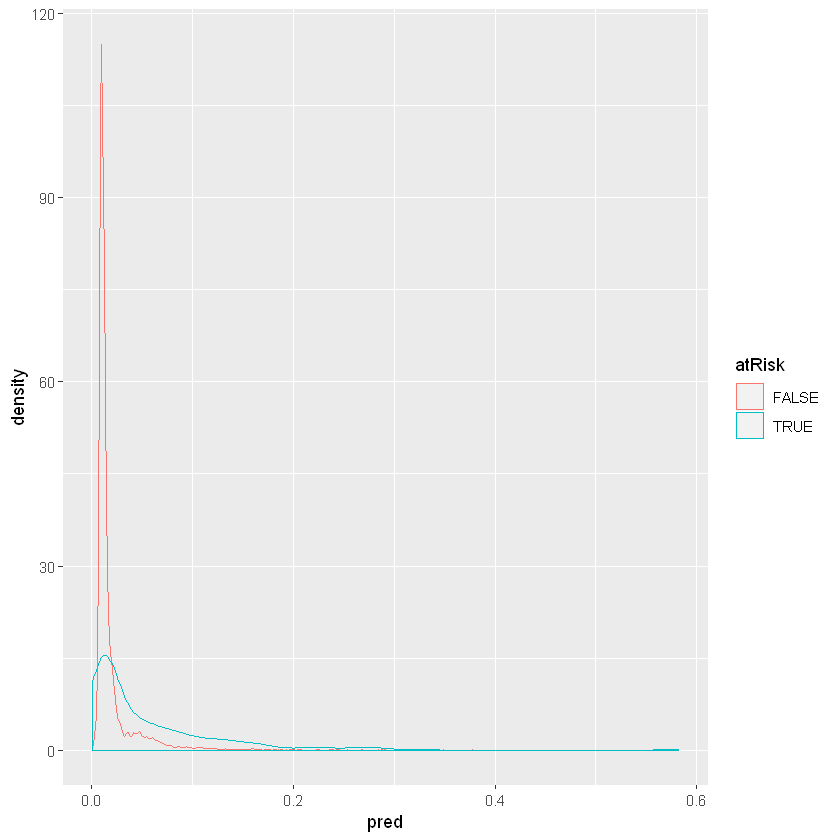

In [9]:
## 3. 예측 모델 만들기 
library(ggplot2)
ggplot(train, aes(x= pred, color=atRisk, lintype=atRisk)) +
 geom_density()

이상적으로는 부정적인 인스턴스의 스코어(false)가 왼쪽에 집중되고 긍정적인 인스턴스에 대한 분포가 오른쪽에 집중되도록 스코어를 분리한다. 현재의 경우 두 분포 모두 왼쪽에 집중되어 있어 양수 및 음수 모두 낮은 스코어를 얻는다. 긍정적인 경우(babies at risk)가 드물기 때문에(모든 출생의 약 1.8%) 이는 그리 놀랍지 않다. 

In [10]:
library(dplyr)
library(ROCR)
library(grid)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ROCR' was built under R version 3.6.2"Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



ROCR (수신자 조작 특성 곡선 = Receiver Operation Characteristic Curve)은 이중 밀도 함수 플롯의 대안으로 알려져 있다. 서로 다른 구분기를 위해 긍정과 부정의 결과 간에 다른 임계치를 얻을 수 있어 참 인식률과 거짓 인식률을 모두 플롯으로 그릴 수 있다. 이 곡선은 분류기를 위해 사용할 수 있고 민감도와 특정률 간의 모든 가능한 트레이드 오프 상황을 표현할 수 있다. *이진분류만 지원 가능하다(Binary Classification)
 y: TPR (TRUE POSITIVE RATE) = 민감도
  ; 실제 Positive 에서 Positive 라고 예측한 비율
 x: FPR (FALSE POSITIVE RATE) = 1 - 특이도 
  ; 특이도 : 실제 negative 에서 negative 예측 비율 
 so, 1 - 특이도 : 실제 negative 에서 positive로 잘못 예측한 비율 
 <b> *** tpr, fpr 은 roc curve 그릴 때 사용 </b>


In [11]:
# threshold (임계값) 수치 기준 이하의 미미한 차이에서는 무시하고 일정 수치 이상에서만 처리한다. 
predObj <- prediction(train$pred, train$atRisk)
precObj <- performance(predObj,measure = "prec")
recObj <- performance(predObj, measure = "rec")

In [12]:
auc <- performance(predObj, measure = "auc")
auc <- auc@y.values[[1]]
auc

[1] 0.6956179

 ROC 곡선이 2번 방향을 향할 수록 AUC는 넓어지는데요,
 모든 case의 결과를 완벽하게 예측하는 모델인 경우 AUC는 1,  무작위로 예측한 모델과 다를 바가 없는 경우 (=reference line) AUC는 0.5의 값을 가지게 됩니다.
 AUC를 판단하는 대략적인 기준은 아래와 같습니다.
- excellent =  0.9~1
- good = 0.8~0.9
- fair = 0.7~0.8
- poor = 0.6~0.7
- fail = 0.5~0.6

In [14]:
precision <- (precObj@y.values)[[1]]
prec.x <- (precObj@x.values)[[1]]
recall <- recObj@y.values[[1]]
 rocFrame <- data.frame(threshold=prec.x, precision=precision, recall=recall)

In [17]:
# 도표 붙히는 함수 
nplot <- function(plist){
  n <- length(plist)
  grid.newpage()
  pushViewport(viewport(layout=grid.layout(n,1)))
  vplayout=function(x,y) {viewport(layout.pos.row = x, layout.pos.col = y)}
  for(i in 1:n){
   print(plist[[i]], vp=vplayout(i,1))
  }
 }

Warning message:
"Removed 1 rows containing missing values (geom_path)."

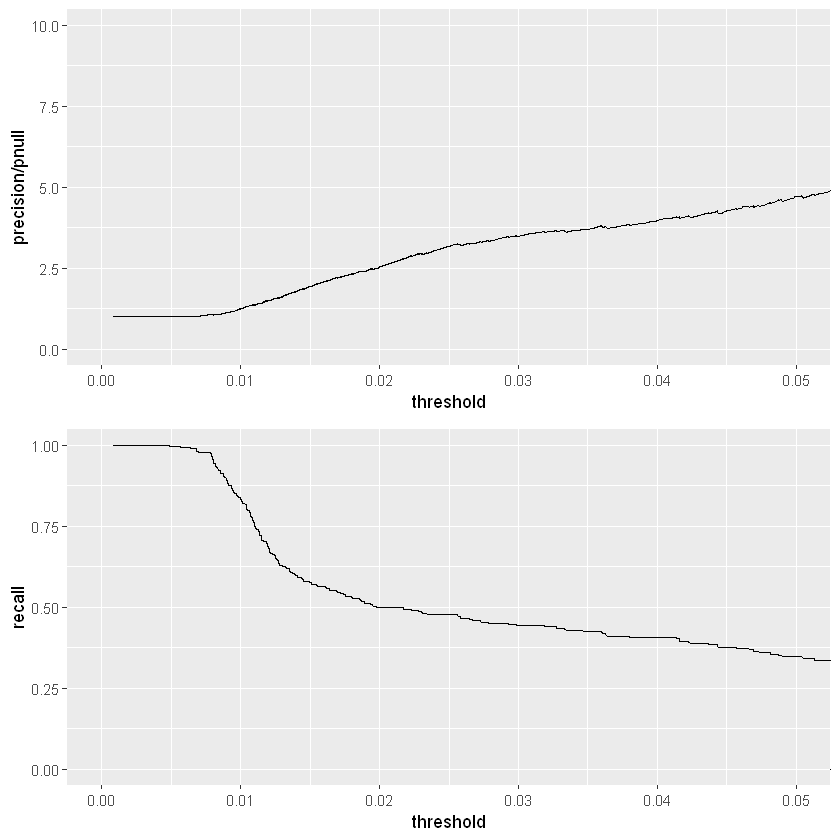

In [18]:
pnull <- mean(as.numeric(train$atRisk)) 
p1 <- ggplot(rocFrame, aes(x=threshold)) +
 geom_line(aes(y=precision/pnull)) + 
 coord_cartesian(xlim= c(0,0.05), ylim=c(0,10))


p2 <- ggplot(rocFrame, aes(x=threshold)) +
 geom_line(aes(y=recall)) + 
 coord_cartesian(xlim= c(0,0.05))
nplot(list(p1,p2))


In [26]:
# 테스트 세트를 사용하여 임계값이 0.02인 분류 기준을 평가해 본다.
# 결과 분류기는 정확도가 낮지만 테스트 세트에서 실제 양성 사례의 55.5% 포함하는 잠재적인 위험에 처한 사례 집합을 식별하며 전체 평균보다 2.66배 높다.  
crab.test <- table(pred=test$pred>0.02, atRist=test$atRisk)
crab.test


       atRist
pred    FALSE TRUE
  FALSE  9487   93
  TRUE   2405  116

In [28]:
precision <- crab.test[2,2]/sum(crab.test[2,])
precision


[1] 0.04601349

In [29]:
recall <- crab.test[2,2]/sum(crab.test[,2])
recall


[1] 0.5550239

In [30]:
enrich <- precision/mean(as.numeric(test$atRisk))
enrich

[1] 2.664159

In [31]:
## 4. 관계 찾기와 조언 추출하기
# exp() = 지수함수란 거듭제곱의 지수를 변수로 하고, 정의역을 실수 전체로 정의하는 초월함수이다. 로그 함수의 역함수.
# x = e^4 = 54.6
# x = exp(4) = 54.6
coefficients(model)

exp(1.545183)
log(1.545183, base=10)

(Intercept)                     PWGT                  UPREVIS 
             -4.41218940               0.00376166              -0.06328943 
             CIG_RECTRUE       GESTREC3< 37 weeks DPLURALtriplet or higher 
              0.31316930               1.54518311               1.39419294 
             DPLURALtwin             ULD_MECOTRUE           ULD_PRECIPTRUE 
              0.31231871               0.81842627               0.19172008 
          ULD_BREECHTRUE             URF_DIABTRUE           URF_CHYPERTRUE 
              0.74923672              -0.34646672               0.56002503 
          URF_PHYPERTRUE            URF_ECLAMTRUE 
              0.16159872               0.49806435

[1] 4.68883

[1] 0.1889799

In [32]:
## 5. 모델 요약값 해석과 계수 품질 규정
summary(model)


Call:
glm(formula = fmla, family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9732  -0.1818  -0.1511  -0.1358   3.2641  

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -4.412189   0.289352 -15.249  < 2e-16 ***
PWGT                      0.003762   0.001487   2.530 0.011417 *  
UPREVIS                  -0.063289   0.015252  -4.150 3.33e-05 ***
CIG_RECTRUE               0.313169   0.187230   1.673 0.094398 .  
GESTREC3< 37 weeks        1.545183   0.140795  10.975  < 2e-16 ***
DPLURALtriplet or higher  1.394193   0.498866   2.795 0.005194 ** 
DPLURALtwin               0.312319   0.241088   1.295 0.195163    
ULD_MECOTRUE              0.818426   0.235798   3.471 0.000519 ***
ULD_PRECIPTRUE            0.191720   0.357680   0.536 0.591951    
ULD_BREECHTRUE            0.749237   0.178129   4.206 2.60e-05 ***
URF_DIABTRUE             -0.346467   0.287514  -1.205 0.22